In [2]:
import wandb
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

api = wandb.Api()


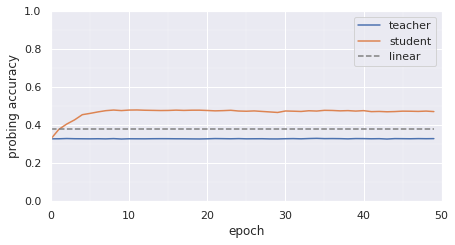

In [90]:
run = api.run('safelix/DINO/runs/t951d1ss')
hist = run.history(keys=['probe/student', 'probe/teacher'])
s_acc = hist['probe/student']
t_acc = hist['probe/teacher']

run = api.run('safelix/DINO/runs/1jexlm4j')
hist = run.history(keys=['probe/student', 'probe/teacher'])
base = pd.concat((hist['probe/student'], hist['probe/teacher'])).mean()

# plot
ax = plt.figure(figsize=(7, 3.5)).gca()
ax.plot(t_acc.index, t_acc, label='teacher')
ax.plot(s_acc.index, s_acc, label='student')
ax.hlines(base, 0, 49, colors='gray', linestyles='--', label='linear')
plt.legend()

ax.set_xlim(0, 50)
ax.set_ylim(-0.0, 1)
ax.set_xticks([5 + 10*i for i in range(5)], minor=True)
ax.set_yticks([0.1 + 0.2*i for i in range(5)], minor=True)
ax.grid(visible=True, which='minor', color='w', linewidth=0.25)

ax.set_xlabel('epoch')
ax.set_ylabel('probing accuracy')
#plt.suptitle('Linear Probing Accuracy')

plt.savefig('radiant-wildflower_probe_v2.pdf', bbox_inches='tight')



In [3]:
# workaround to get runs associated with sweep https://github.com/wandb/wandb/issues/3347
sweep = api.sweep('safelix/DINO/sweeps/am04wjt4')
non_defining_config_keys = ['logdir', 'from_json', 'seed', 'out_dim']
order_by = 'config.out_dim.value'

def filter_from_config(config, exclude_keys):
    for key in exclude_keys:
        if key in config.keys():
            del config[key]
    
    return [{f'config.{key}':val} for (key, val) in config.items()]

filters = filter_from_config(sweep.runs[0].config, non_defining_config_keys)
runs = api.runs('safelix/DINO', filters={"$and": filters}, order=order_by)

print('Found', len(runs), 'runs:')
print(runs.objects)

Found 12 runs:
[<Run safelix/DINO/3ohf57xt (finished)>, <Run safelix/DINO/lfp5818z (finished)>, <Run safelix/DINO/plpjfoez (finished)>, <Run safelix/DINO/1mm4167o (finished)>, <Run safelix/DINO/2o9rg4m0 (finished)>, <Run safelix/DINO/3sxa7zkz (finished)>, <Run safelix/DINO/r02w9hdy (finished)>, <Run safelix/DINO/aq7fvdr5 (finished)>, <Run safelix/DINO/4s1fywyr (finished)>, <Run safelix/DINO/4azg0yaz (finished)>, <Run safelix/DINO/pggxvtk4 (finished)>, <Run safelix/DINO/2azx46kw (finished)>]


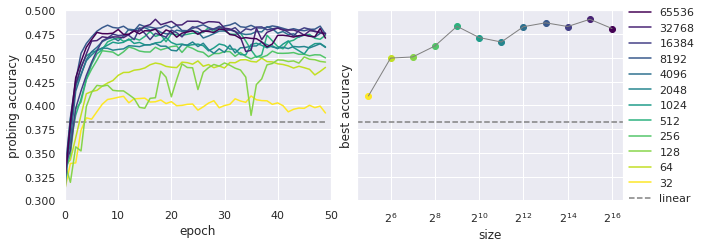

In [11]:
from matplotlib.cm import ScalarMappable, viridis, viridis_r
from matplotlib.colors import BoundaryNorm, NoNorm

f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3.5))

dims = [run.config['out_dim'] for run in runs]
cmap = ScalarMappable(norm=BoundaryNorm(dims, viridis_r.N, extend='max'), cmap=viridis_r)

# get baseline
run = api.run('safelix/DINO/runs/1jexlm4j')
hist = run.history(keys=['probe/student', 'probe/teacher'])
base = pd.concat((hist['probe/student'], hist['probe/teacher'])).mean()
ax[0].hlines(base, 0, 49, colors='gray', linestyles='--', label='linear')
ax[1].hlines(base, 2**4.5, 2**16.5, colors='gray', linestyles='--', label='linear')

# Make plots 
max_acc = []
for run in runs:
    hist = run.history(keys=['probe/student', 'probe/teacher'])
    s_acc = hist['probe/student']
    out_dim = run.config['out_dim']
    max_acc.append(s_acc.max())

    ax[0].plot(s_acc.index, s_acc, label=out_dim, color=cmap.to_rgba(out_dim))
    ax[1].scatter(out_dim, s_acc.max(), label=out_dim, color=cmap.to_rgba(out_dim))
ax[1].plot(dims, max_acc, color='gray', linestyle='-', linewidth=1)


# Format Left Plot
#plt.colorbar(mappable=cmap, ticks=dims, extendrect=True, drawedges=True)
#ax[0].legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False,  borderpad=0)
ax[0].set_xlim(0, 50)
ax[0].set_ylim(0.3, 0.5)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('probing accuracy')

# Format Left Plot
#plt.colorbar(mappable=cmap, ticks=dims, extendrect=True, drawedges=True)
handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False,  borderpad=0)
ax[1].set_xscale('log', base=2) 
ax[1].set_xlim(2**4.5, 2**16.5)
ax[1].set_ylim(0.3, 0.5)
ax[1].set_xlabel('size')
ax[1].set_ylabel('best accuracy')


plt.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig('init-distill-outdim.pdf', bbox_inches='tight')


In [ ]:
hist = run.history(keys=['probe/student', 'probe/teacher'])
s_acc = hist['probe/student']
t_acc = hist['probe/teacher']

run = api.run('safelix/DINO/runs/1jexlm4j')
hist = run.history(keys=['probe/student', 'probe/teacher'])
base = pd.concat((hist['probe/student'], hist['probe/teacher'])).mean()

# plot
ax = plt.figure(figsize=(7, 3.5)).gca()
ax.plot(t_acc.index, t_acc, label='teacher')
ax.plot(s_acc.index, s_acc, label='student')
ax.hlines(base, 0, 49, colors='gray', linestyles='--', label='linear')
plt.legend()

ax.set_xlim(0, 50)
ax.set_ylim(-0.0, 1)
ax.set_xticks([5 + 10*i for i in range(5)], minor=True)
ax.set_yticks([0.1 + 0.2*i for i in range(5)], minor=True)
ax.grid(visible=True, which='minor', color='w', linewidth=0.25)

ax.set_xlabel('epoch')
ax.set_ylabel('probing accuracy')
#plt.suptitle('Linear Probing Accuracy')

plt.savefig('radiant-wildflower_probe_v2.pdf', bbox_inches='tight')



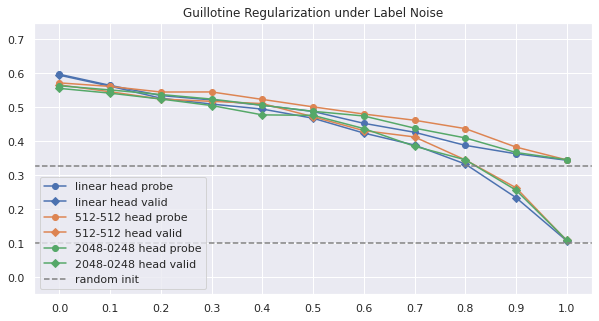

In [2]:
sweeps = [
    ('linear head', api.sweep('safelix/DINO/sweeps/qmhuwk3y'), 'C0'),
    ('512-512 head', api.sweep('safelix/DINO/sweeps/473v5acw'), 'C1'),
    ('2048-2048 head', api.sweep('safelix/DINO/sweeps/y1qqvpw1'), 'C2'),
]


ax = plt.figure(figsize=(10, 5)).gca()
h_probe, h_valid = [], []
for name, sweep, color in sweeps:
    xs, ys_probe, ys_valid = [], [], []
    for run in sweep.runs:
        xs.append(run.config['label_noise_ratio'])
        ys_probe.append(run.summary['probe/student']['max'])
        ys_valid.append(run.summary['valid/s_acc']['max'])

        hist = run.history(keys=['probe/student', 'valid/s_acc'])
        h_probe.append(hist['probe/student'][0])
        h_valid.append(hist['valid/s_acc'][0])
    ax.plot(xs, ys_probe, '-o', c=color, label=f'{name} probe')
    ax.plot(xs, ys_valid, '-D', c=color, label=f'{name} valid')

h_probe = sum(h_probe) / len(h_probe)
h_valid = sum(h_valid) / len(h_valid)
ax.hlines(h_probe, -0.05, 1.05, colors='gray', linestyles='--', label='random init')
ax.hlines(h_valid, -0.05, 1.05, colors='gray', linestyles='--')


ax.set_ylim(-0.05,0.75)
ax.set_xlim(-0.05,1.05)
ax.set_xticks(xs)

plt.legend()
plt.title('Guillotine Regularization under Label Noise')
plt.savefig('label_flipping_gr.pdf')
